In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler


In [5]:
def add_features(X):
    X = X.copy()
    
    # Week-of-month categorical
    X["week_of_month"] = pd.cut(
        X["day"],
        bins=[0, 7, 14, 21, np.inf],
        labels=["week1", "week2", "week3", "week4"]
    )
    
    # Years since start numeric
    X["years_since_start"] = X["year"] - X["year"].min()
    
    return X


In [6]:
df=pd.read_csv("data/processed_Data.csv").dropna(how='any',axis=0).reset_index(drop=True)



In [7]:
label_attrib=["price"]
raw_attrib=["day"]
strata="year"
cat_attribs=["month","week_of_month"]
num_features=["years_since_start"]

In [8]:
def stratifiedshufflesplitter(df, bins, strata_col, test_size):
    """
    Performs stratified shuffle split based on income bins of median income value
    """
    df = df.copy()
    strata_cat = "__strata__"
    df[strata_cat] = pd.qcut(df[strata_col], q=bins, labels=False,    duplicates="drop")

    split = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=24
    )

    for train_idx, test_idx in split.split(df, df[strata_cat]):
        train = df.loc[train_idx].drop(strata_cat, axis=1)
        test = df.loc[test_idx].drop(strata_cat, axis=1)

    return train, test


In [9]:
train,test= stratifiedshufflesplitter(df,10,strata,0.2) 

In [10]:
feature_adder = FunctionTransformer(add_features)
num_pipeline=Pipeline([
    ("min-max", MinMaxScaler(feature_range=(-1, 1)))
])
cat_pipeline=Pipeline([
    ("encoding",OneHotEncoder(handle_unknown="ignore"))
])

full_pipeline = Pipeline([
    ("feature_adder", feature_adder),  # add engineered features
    ("preprocessor", ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_attribs)
    ]))
])

In [11]:
X=full_pipeline.fit_transform(train)
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5889 stored elements and shape (1963, 17)>

In [12]:

cat_encoder = full_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoding"]
cat_encoded_attribs = cat_encoder.get_feature_names_out(cat_attribs)
num_encoded_attribs = list(num_features) + list(cat_encoded_attribs)

# num_encoded_attribs


In [13]:
X_prepared=pd.DataFrame(X.toarray(),columns=num_encoded_attribs,index=train.index)
# X
X_prepared
# print(train)
# print(cat_attribs)
# print(num_features)

,years_since_start,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week_of_month_week1,week_of_month_week2,week_of_month_week3,week_of_month_week4
83,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1865,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
878,0.142857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
868,0.142857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
167,0.714286,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,-0.714286,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
344,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2203,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
989,0.142857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
lin_reg = LinearRegression()
y_train=train[label_attrib]
lin_reg.fit(X_prepared, y_train)
lin_preds = lin_reg.predict(X_prepared)
lin_rmse=root_mean_squared_error(y_train,lin_preds)
lin_rmses=-cross_val_score(lin_reg,X_prepared,y_train,scoring="neg_root_mean_squared_error",cv=10)
print(pd.Series(lin_rmses).describe())
print(lin_rmse,lin_rmses.mean())


count     10.000000
mean     282.824229
std       29.344259
min      244.273127
25%      261.749635
50%      280.050126
75%      311.804565
max      320.167677
dtype: float64
282.46469846459144 282.82422859686017


In [21]:
tree_reg=DecisionTreeRegressor()
y_train=train[label_attrib]
tree_reg.fit(X_prepared, y_train)
tree_preds = tree_reg.predict(X_prepared)
tree_rmse=root_mean_squared_error(y_train,tree_preds)
tree_rmses=-cross_val_score(tree_reg,X_prepared,y_train,scoring="neg_root_mean_squared_error",cv=10)
print(pd.Series(tree_rmses).describe())
print(tree_rmse,tree_rmses.mean())

count    10.000000
mean     32.433566
std       7.777672
min      22.779277
25%      25.682486
50%      32.284798
75%      37.161689
max      45.814809
dtype: float64
26.281153616442655 32.43356560633383


In [22]:
forest_reg=RandomForestRegressor()
y_train=train[label_attrib]
forest_reg.fit(X_prepared, y_train)
forest_preds = forest_reg.predict(X_prepared)
forest_rmse=root_mean_squared_error(y_train,forest_preds)
forest_rmses=-cross_val_score(forest_reg,X_prepared,y_train,scoring="neg_root_mean_squared_error",cv=10)
print(pd.Series(forest_rmses).describe())
print(forest_rmse,forest_rmses.mean())

c:\Programs\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Programs\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Programs\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Programs\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

count    10.000000
mean     32.093788
std       7.666449
min      21.837562
25%      25.663166
50%      31.818400
75%      36.906577
max      44.844700
dtype: float64
26.309862223678795 32.09378750831918


In [23]:
results = pd.DataFrame({
    "Actual": y_train.squeeze(),
    "Predicted": tree_preds.ravel()
})

# View the first few rows
print(results.head())

# Or get descriptive stats side by side
print(results.describe())

      Actual    Predicted
83    2538.0  2499.250000
1865  1161.5  1144.500000
878   1239.0  1211.428571
868   1174.5  1177.642857
167   1864.5  1851.928571
            Actual    Predicted
count  1963.000000  1963.000000
mean   1201.909857  1201.909857
std     506.429037   505.746298
min     600.000000   605.500000
25%     994.500000   995.877778
50%    1123.000000  1114.500000
75%    1256.000000  1255.916667
max    4454.000000  4243.875000


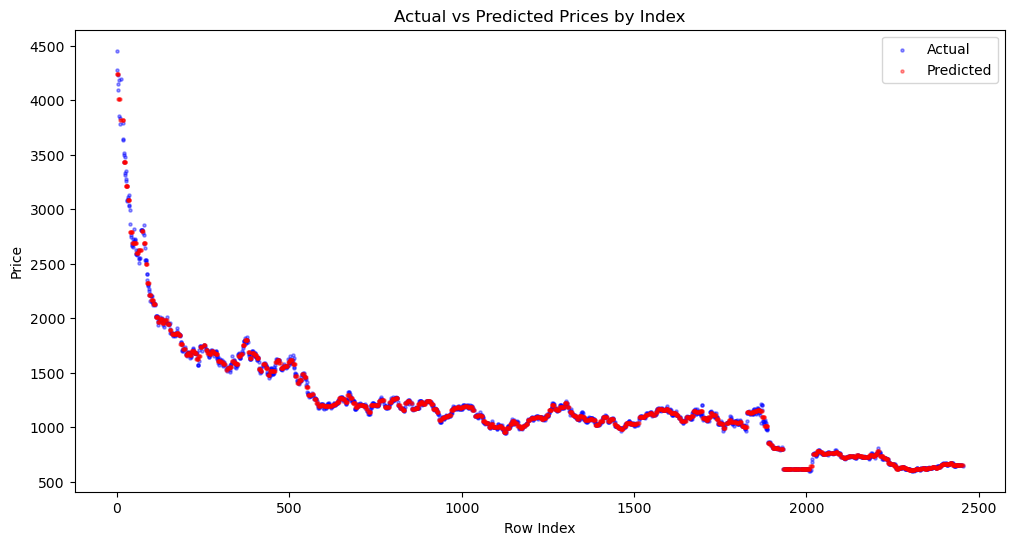

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot Actual prices
plt.scatter(train.index, results["Actual"], color='blue',s=5, alpha=0.4, label="Actual")

# Plot Predicted prices
plt.scatter(train.index, results["Predicted"], color='red',s=5, alpha=0.4, label="Predicted")

plt.xlabel("Row Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices by Index")
plt.legend()
plt.show()
